
# Figure 3b: Image Segmentation

Used "hiprfish_imaging_py38" conda environment



=============================================================================
## Setup
=============================================================================



Imports.


In [1]:
import glob
import pandas as pd
import subprocess
import yaml
import gc
import os
import re
import javabridge
import bioformats
import sys
gc.enable()  # Garbage cleanup



Move to the working directory (workdir) you want.


In [2]:
# Absolute path
project_workdir = '/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/code/fig_3/fig_3b'

os.chdir(project_workdir)
os.getcwd()  # Make sure you're in the right directory


'/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/code/fig_3/fig_3b'


Go into your configuration file and adjust all of the 'Paths' so they are relative to the workdir.

Also adjust the 'Inputs' parameters to fit the images.


In [3]:
config_fn = 'config.yaml' # relative path to config file from workdir

with open(config_fn, 'r') as f:
    config = yaml.safe_load(f)



Load specialized modules. Make sure you have the [segmentation pipeline](https://github.com/benjamingrodner/pipeline_segmentation).


In [4]:
%load_ext autoreload
%autoreload 2

sys.path.append(config['pipeline_path'] + '/' + config['functions_path'])
import image_plots as ip
import segmentation_func as sf
import spot_funcs as spf



=============================================================================
## Set segmentation parameters
=============================================================================



Get the input filenames. Reload the config file if you need to update the regular expression.


In [5]:
input_filenames = glob.glob(config['input_dir'] + '/' + config['input_regex']
                            + config['input_ext'])
input_filenames.sort()
print(len(input_filenames))
input_filenames


2


['../../../data/fig_3/fig_3b/2021_08_26_plaqueamrintegrated_probe_plasmid_sample_bmg_rep_2_fov_tile1_Airyscan_Processing_Stitch.czi',
 '../../../data/fig_3/fig_3b/2021_08_26_plaqueamrintegrated_probe_plasmid_sample_hs_rep_2_fov_tile1_Airyscan_Processing_Stitch.czi']


Select an image to test segmentation parameters


In [6]:
test_index = 1
input_fn = input_filenames[test_index]
input_fn


'../../../data/fig_3/fig_3b/2021_08_26_plaqueamrintegrated_probe_plasmid_sample_hs_rep_2_fov_tile1_Airyscan_Processing_Stitch.czi'

In [7]:
javabridge.start_vm(class_path=bioformats.JARS)
input = bioformats.load_image(input_fn)
input.shape


18:38:43.631 [Thread-0] DEBUG loci.common.NIOByteBufferProvider - Using mapped byte buffer? false
18:38:43.787 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382) ~[na:1.8.0_265]
	at java.lang.ClassLoader.loadClass(ClassLoader.java:419) ~[na:1.8.0_265]
	at sun.misc.Launcher$AppClassLoader.loadClass(Launcher.java:352) ~[na:1.8.0_265]
	at java.lang.ClassLoader.loadClass(ClassLoader.java:352) ~[na:1.8.0_265]
	at java.lang.Class.forName0(Native Method) ~[na:1.8.0_265]
	at java.lang.Class.forName(Class.java:264) ~[na:1.8.0_265]
	at loci.formats.ClassList.parseLine(ClassList.java:196) [bioformats_package.jar:6.5.1]
	at loci.formats.ClassList.parseFile(ClassList.java:258) [bioformats_package.jar:6.5.1]
	at loci.formats.ClassList.<init>(ClassList.java:138) [bioformats_package.jar:6.5.1]
18:38:43.848 [Thread-0] DEBUG loci.formats.ClassList - C

18:38:44.857 [Thread-0] DEBUG o.scijava.nativelib.BaseJniExtractor - Extracting 'jar:file:/home/bmg224/miniconda3/envs/hiprfish_imaging_py38/lib/python3.8/site-packages/bioformats/jars/bioformats_package.jar!/META-INF/lib/linux_64/libturbojpeg.so' to '/tmp/libturbojpeg8164586984421281985.so'
18:38:45.053 [Thread-0] DEBUG loci.common.services.ServiceFactory - Loaded properties from: services.properties
18:38:45.054 [Thread-0] DEBUG loci.common.services.ServiceFactory - Added interface interface loci.formats.services.POIService and implementation class loci.formats.services.POIServiceImpl
18:38:45.054 [Thread-0] DEBUG loci.common.services.ServiceFactory - Added interface interface loci.formats.services.MDBService and implementation class loci.formats.services.MDBServiceImpl
18:38:45.055 [Thread-0] DEBUG loci.common.services.ServiceFactory - Added interface interface loci.formats.services.JPEGTurboService and implementation class loci.formats.services.JPEGTurboServiceImpl
18:38:45.055 [Th

(8319, 9970, 4)

In [8]:
n_channels = input.shape[2]
n_channels


4

(<Figure size 1440x360 with 4 Axes>, <AxesSubplot:>, [])

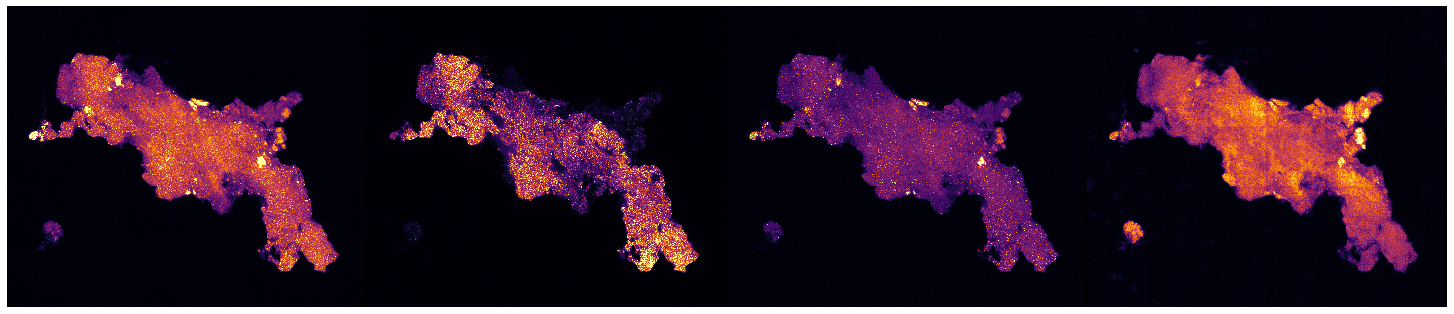

In [9]:
clims = [(0,0.05),(0,0.05),(0,0.05),(0,0.25)] # One color threshold tuple per channel
im_list = [input[:,:,i] for i in range(n_channels)]
ip.subplot_square_images(im_list, (1,n_channels), clims=clims)



Subset the image for faster results during parameter selection.


(<Figure size 1440x360 with 4 Axes>, <AxesSubplot:>, [])

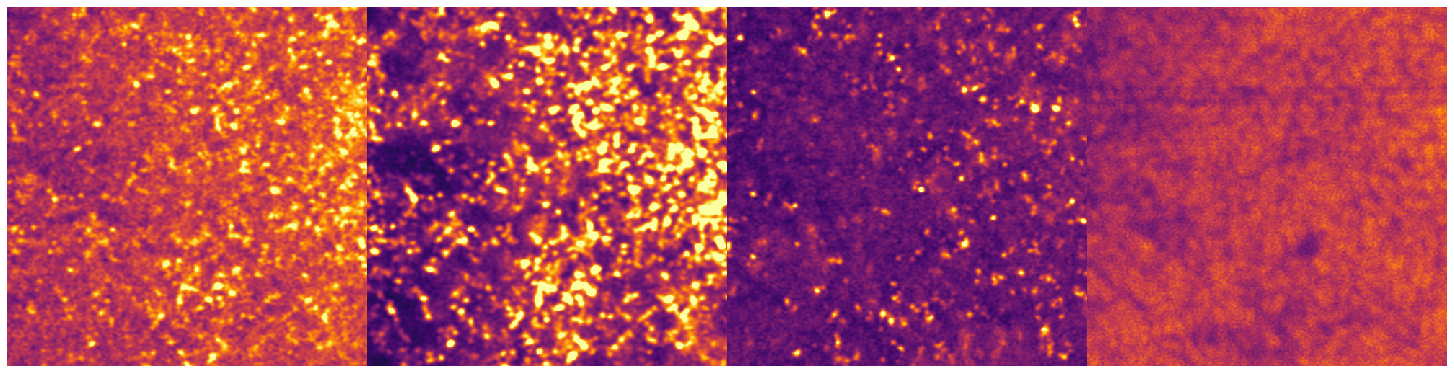

In [10]:
sr = [(2000,2500),(2000, 2500)]
input_sub = input[sr[0][0]:sr[0][1],sr[1][0]:sr[1][1]]
im_list = [input_sub[:,:,i] for i in range(n_channels)]
ip.subplot_square_images(im_list, (1,n_channels), clims=clims)



Get cell seg channels.


In [11]:
im_cell_list = [input[:,:,i] for i in config['cell_seg']['channels']]
# im_cell_list = [input_sub[:,:,i] for i in config['cell_seg']['channels']]
if len(im_cell_list) > 1:
    im_cell = np.max((np.dstack(im_cell_list)), axis=2)
else:
    im_cell = im_cell_list[0]
im_cell.shape


(8319, 9970)


Test spot seg parameters, adjust in the configuration file, and repeat until it's good. Also repeat with differnt subset regions.


In [12]:
im_cell_mask_old, im_cell_pre_old, im_cell_seg_old = [sf.np.zeros((2,2))]*3
im_cell_seg_old[0,0] = 1


old


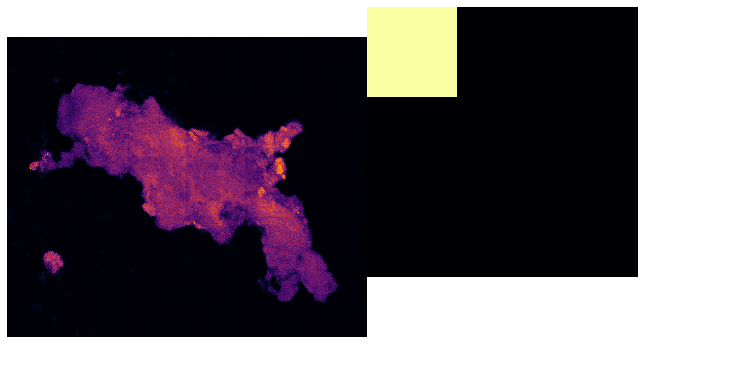

new


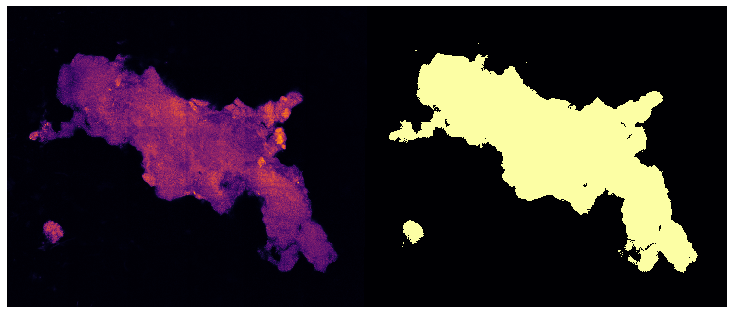

In [13]:
with open(config_fn, 'r') as f:
    config = yaml.safe_load(f)
pdict = config['cell_seg']

im_cell_mask = sf.get_background_mask(
    im_cell,
    bg_filter=pdict['bg_filter'],
    bg_log=pdict['bg_log'],
    bg_smoothing=pdict['bg_smoothing'],
    n_clust_bg=pdict['n_clust_bg'],
    top_n_clust_bg=pdict['top_n_clust_bg'],
    bg_threshold=pdict['bg_threshold']
    )
print('old')
ip.subplot_square_images([im_cell, im_cell_mask_old], (1,2))
ip.plt.show()
print('new')
ip.subplot_square_images([im_cell, im_cell_mask], (1,2))
im_cell_mask_old = im_cell_mask


In [14]:
zc = [2000, 2000]
zs = [500, 500]
with open(config_fn, 'r') as f:
    config = yaml.safe_load(f)
pdict = config['cell_seg']

im_cell_pre = sf.pre_process(
    im_cell[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
    log=pdict['pre_log'],
    denoise=pdict['pre_denoise'],
    gauss=pdict['pre_gauss'],
    diff_gauss=eval(pdict['diff_gauss'])
    )

im_cell_seg = sf.segment(
    im_cell_pre,
    background_mask = im_cell_mask[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
    n_clust=pdict['n_clust'],
    small_objects=pdict['small_objects']
    )


old


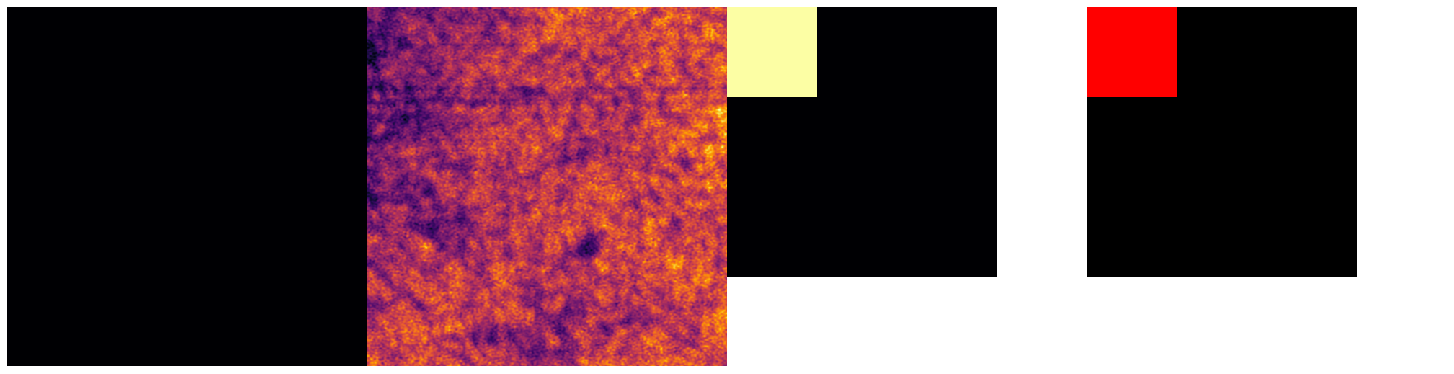

new


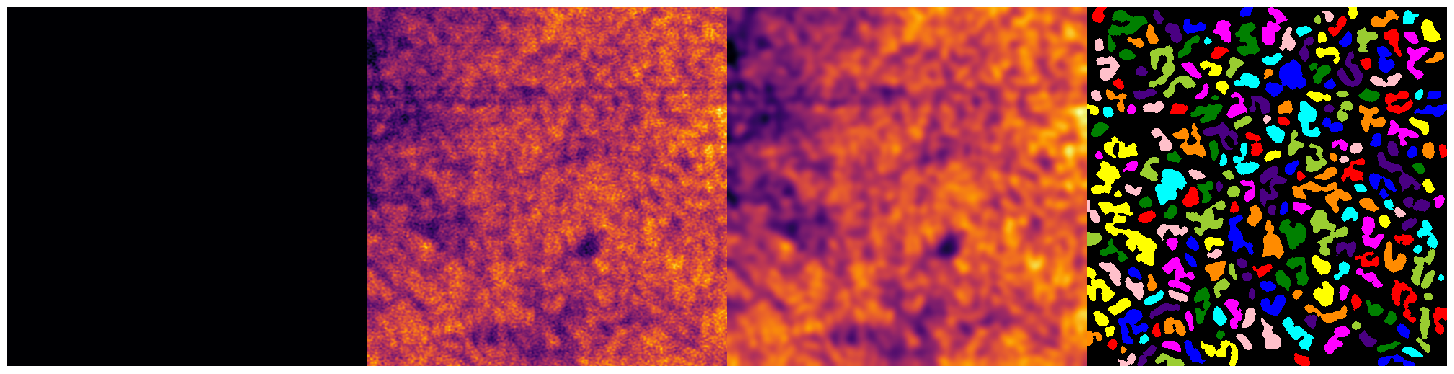

In [15]:
print('old')
im_list = [im_cell_mask_old[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
           im_cell[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]], im_cell_pre_old,
           ip.seg2rgb(im_cell_seg_old)]
ip.subplot_square_images(im_list, (1,4))
ip.plt.show()
print('new')
im_list = [ im_cell_mask[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
            im_cell[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]], im_cell_pre,
            ip.seg2rgb(im_cell_seg)]
ip.subplot_square_images(im_list, (1,4))
im_cell_pre_old = im_cell_pre
im_cell_seg_old = im_cell_seg
# seg_clims = max([clims[i] for i in config['cell_seg']['channels']])
# ip.subplot_square_images(im_list, (1,4), clims=(seg_clims, seg_clims,'',''))



Images above from left to right: Raw, pre-processed, background mask, final segmentation.

Below the segmentation projected onto the raw image


<Axes:>

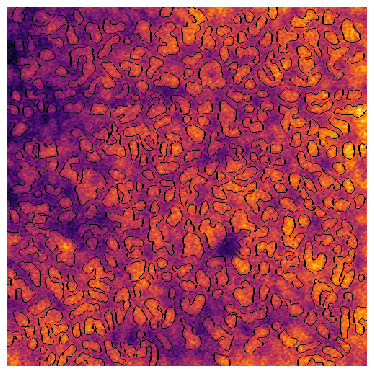

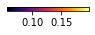

In [16]:
fig, ax, cbar = ip.plot_image(im_cell[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]], cmap='inferno')
ip.plot_seg_outline(ax, im_cell_seg, col=(0,0,0))



Test spot seg parameters, adjust in the configuration file, and repeat until it's good. Check all the spot seg channels.


In [17]:
sp=0
im_spot_list = [input[:,:,i] for i in config['spot_seg']['channels']]
im_spot = im_spot_list[sp]


In [18]:
im_spot_mask_old, im_spot_pre_old, im_spot_seg_old = [sf.np.zeros((2,2))]*3
im_spot_seg_old[0,0] = 1


old


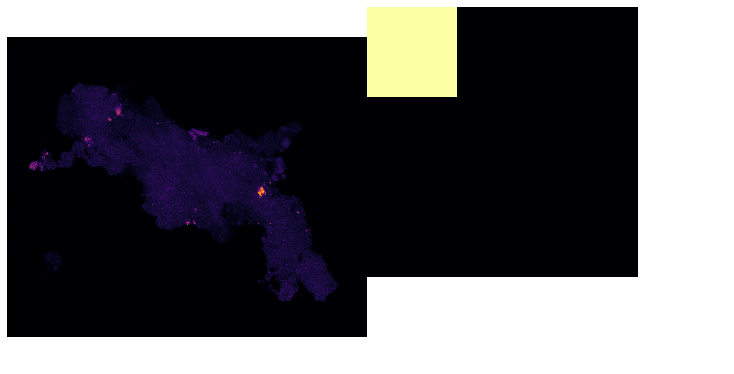

new


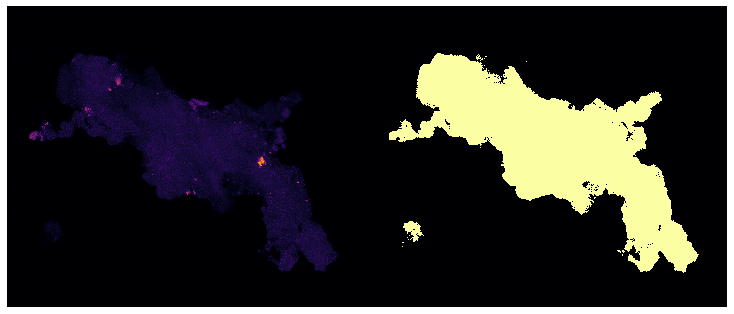

In [19]:
with open(config_fn, 'r') as f:
    config = yaml.safe_load(f)
pdict = config['spot_seg']

im_spot_mask = sf.get_background_mask(
    im_spot,
    bg_filter=pdict['bg_filter'],
    bg_log=pdict['bg_log'],
    bg_smoothing=pdict['bg_smoothing'],
    n_clust_bg=pdict['n_clust_bg'],
    top_n_clust_bg=pdict['top_n_clust_bg'],
    bg_threshold=pdict['bg_threshold']
    )
print('old')
ip.subplot_square_images([im_spot, im_spot_mask_old], (1,2))
ip.plt.show()
print('new')
ip.subplot_square_images([im_spot, im_spot_mask], (1,2))
im_spot_mask_old = im_spot_mask


In [20]:
zc = [4000, 4000]
zs = [500, 500]
with open(config_fn, 'r') as f:
    config = yaml.safe_load(f)
pdict = config['spot_seg']

im_spot_pre = sf.pre_process(
    im_spot[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
    log=pdict['pre_log'],
    denoise=pdict['pre_denoise'],
    gauss=pdict['pre_gauss'],
    diff_gauss=eval(pdict['diff_gauss'])
    )

im_spot_seg = sf.segment(
    im_spot_pre,
    background_mask = im_spot_mask[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
    n_clust=pdict['n_clust'],
    small_objects=pdict['small_objects']
    )


old


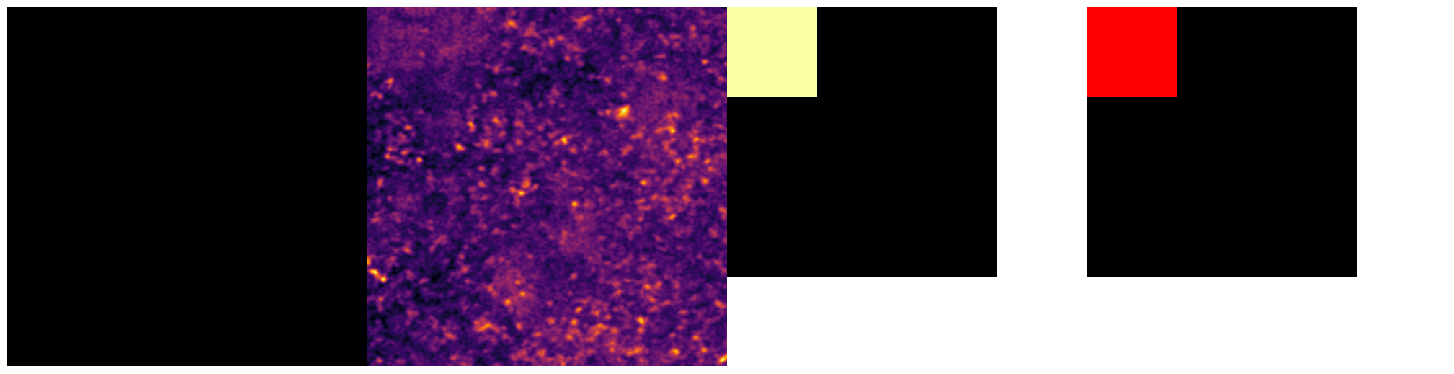

new


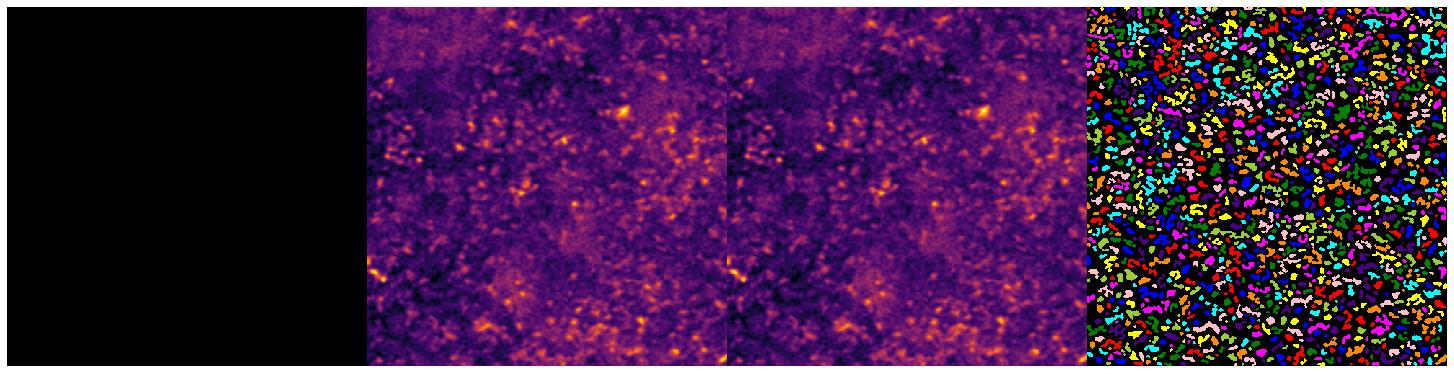

In [21]:
print('old')
im_list = [im_spot_mask_old[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
           im_spot[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]], im_spot_pre_old,
           ip.seg2rgb(im_spot_seg_old)]
ip.subplot_square_images(im_list, (1,4))
ip.plt.show()
print('new')
im_list = [ im_spot_mask[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
            im_spot[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]], im_spot_pre,
            ip.seg2rgb(im_spot_seg)]
ip.subplot_square_images(im_list, (1,4))
im_spot_pre_old = im_spot_pre
im_spot_seg_old = im_spot_seg
# seg_clims = max([clims[i] for i in config['cell_seg']['channels']])
# ip.subplot_square_images(im_list, (1,4), clims=(seg_clims, seg_clims,'',''))



Images above from left to right: Raw, pre-processed, background mask, final segmentation.

Below the segmentation projected onto the raw image


<Axes:>

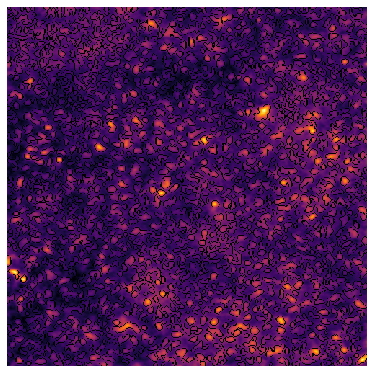

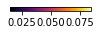

In [22]:
fig, ax, cbar = ip.plot_image(im_spot[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]], cmap='inferno')
ip.plot_seg_outline(ax, im_spot_seg, col=(0,0,0))



Adjust the local maxima minimum distance parameter. Segmentations with more than one local maximum will be split into different segmentations


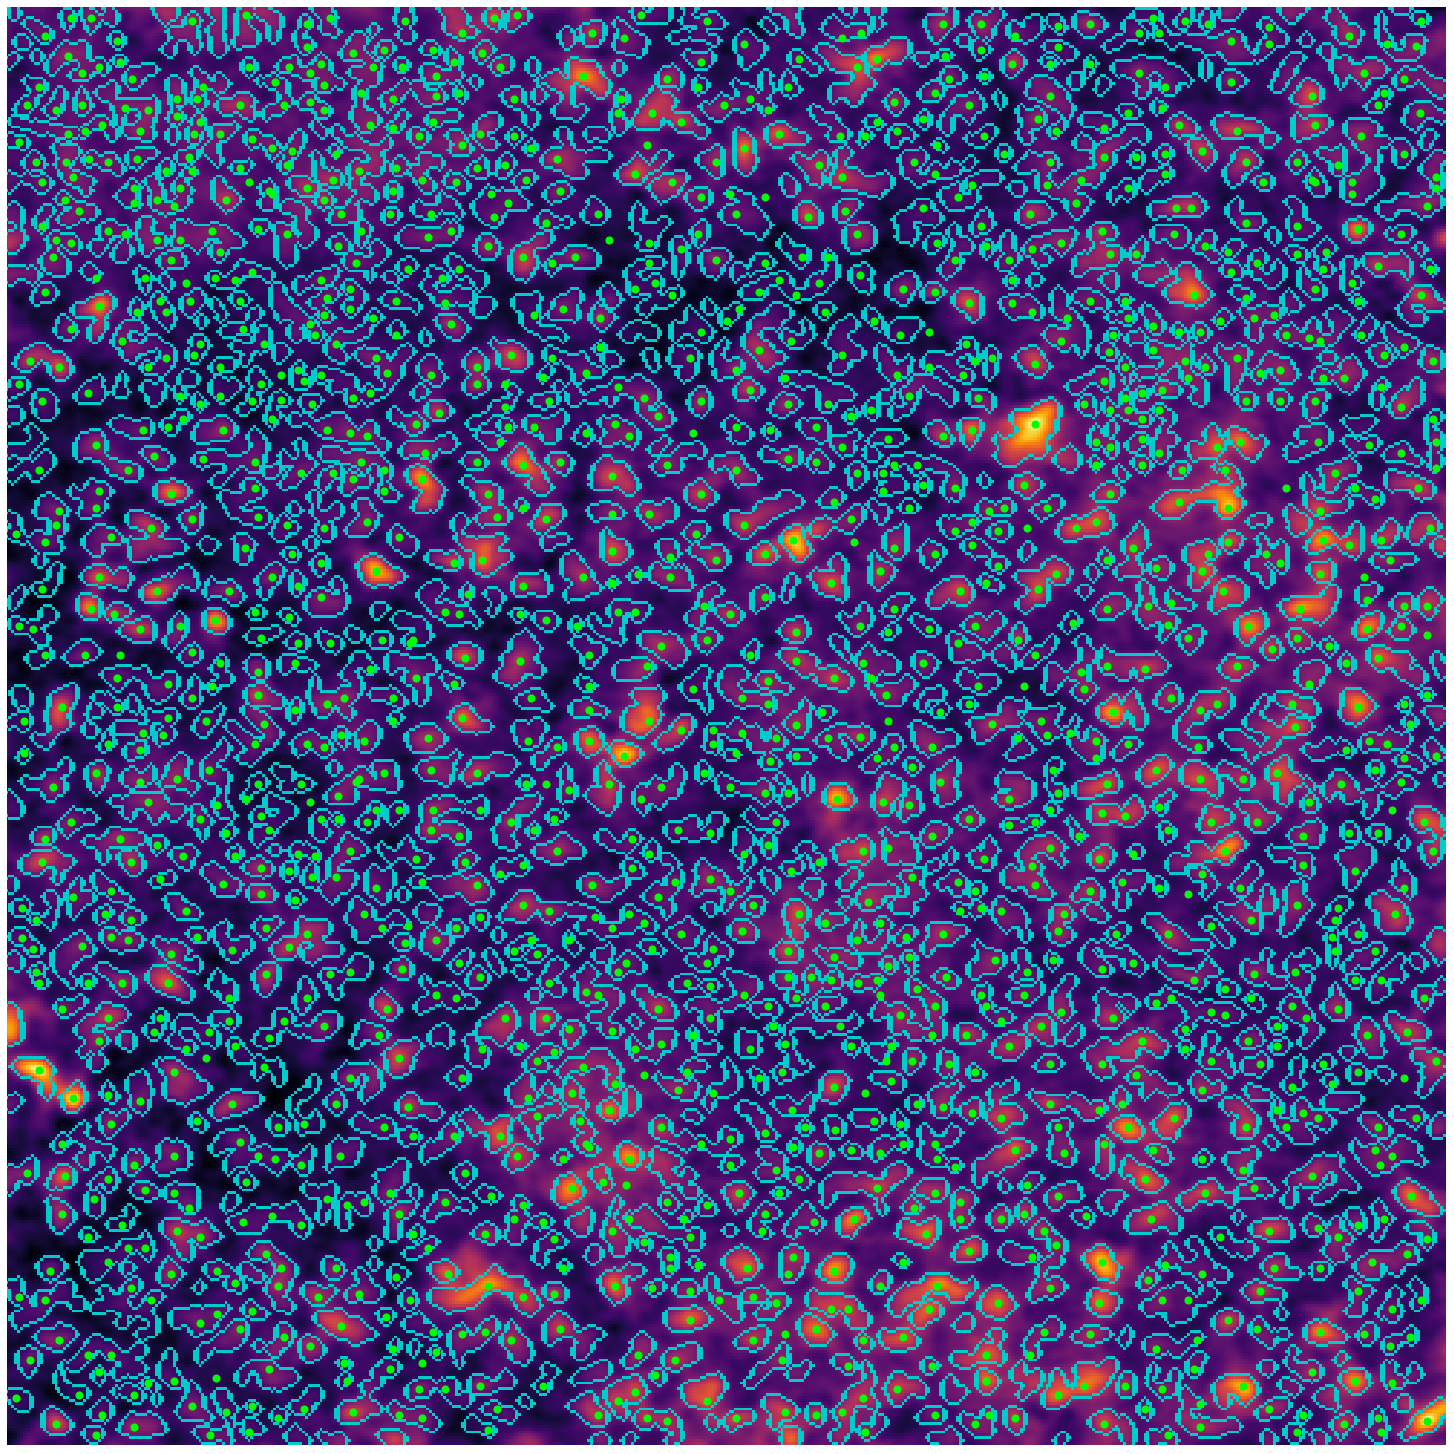

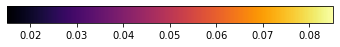

In [23]:
with open(config_fn, 'r') as f:
    config = yaml.safe_load(f)

# maxs = spf.peak_local_max(im_spot, min_distance = config['local_max_mindist'])
ma = spf._get_merged_peaks(im_spot[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
                            min_distance=config['local_max_mindist'])
# is_peak = spf.peak_local_max(im_spot, indices=False, min_distance=config['local_max_mindist']) # outputs bool image
# is_peak.shape
# labels = spf.label(is_peak)[0]
# merged_peaks = spf.center_of_mass(is_peak, labels, range(1, np.max(labels)+1))
# ma = np.array(merged_peaks)
fig, ax, cbar = ip.plot_image(im_spot[zc[0]:zc[0]+zs[0],zc[1]:zc[1]+zs[1]],
                              cmap='inferno', im_inches=20)
ax.scatter(ma[:,1],ma[:,0], s=50, color=(0,1,0))
ax = ip.plot_seg_outline(ax, im_spot_seg, col=(0,0.8,0.8))
# ax.set_xlim((300,400))
# ax.set_ylim((425,475))


=============================================================================
## Run the pipeline
=============================================================================

To run a test of the pipeline write an input table with only one file.


In [24]:
input_fns_split = [os.path.split(fn)[1] for fn in [input_fn]]
sample_names = [re.sub(config['input_ext'], '', fn) for fn in input_fns_split]
input_table = pd.DataFrame(sample_names, columns=config['input_table_cols'])
input_table.to_csv(config['input_table_fn'], index=False)
sample_names


['2021_08_26_plaqueamrintegrated_probe_plasmid_sample_hs_rep_2_fov_tile1']


To run all the samples write a full input table.


In [25]:
input_fns_split = [os.path.split(fn)[1] for fn in input_filenames]
sample_names = [re.sub(config['input_ext'], '', fn) for fn in input_fns_split]
input_table = pd.DataFrame(sample_names, columns=config['input_table_cols'])
input_table.to_csv(config['input_table_fn'], index=False)
input_table.values


array([['2021_08_26_plaqueamrintegrated_probe_plasmid_sample_bmg_rep_2_fov_tile1'],
       ['2021_08_26_plaqueamrintegrated_probe_plasmid_sample_hs_rep_2_fov_tile1']],
      dtype=object)


Write the snakemake execution code to a bash script.


In [26]:
dry_run = False  # Just create DAG if True
n_cores = 2  # number of allowed cores for the snakemake to use
force_run = 'segment_cells'  # Pick a rule to re-run. False if you don't want a force run.

snakefile = config['snakefile']
dr = '-pn' if dry_run else '-p'
fr = '-R ' + force_run if force_run else ''
command = " ".join(['snakemake', '-s', snakefile, '--configfile', config_fn, '-j',
                    str(n_cores), dr, fr])

with open(config['run_fn'], 'w') as f:
    f.write(command)

command


'snakemake -s Snakefile --configfile config.yaml -j 2 -p -R segment_cells'


Now execute the script in the command line.

```console
$ conda activate hiprfish_imaging_py38
$ cd /fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/code/fig_3/fig_3b
$ sh run.sh
```

Check the segmentation


2021_08_26_plaqueamrintegrated_probe_plasmid_sample_bmg_rep_2_fov_tile1
Cell channel  3


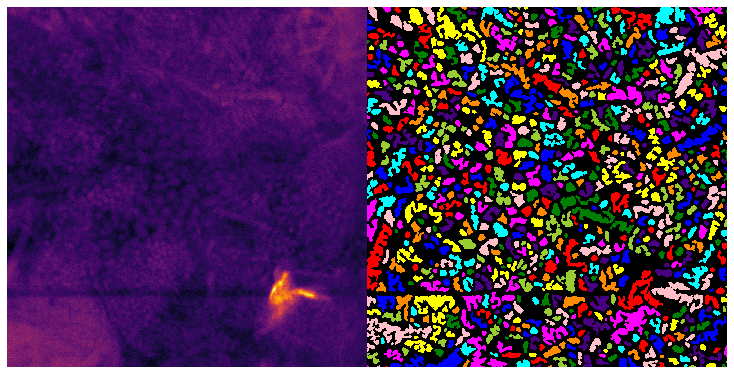

Spot channel  0


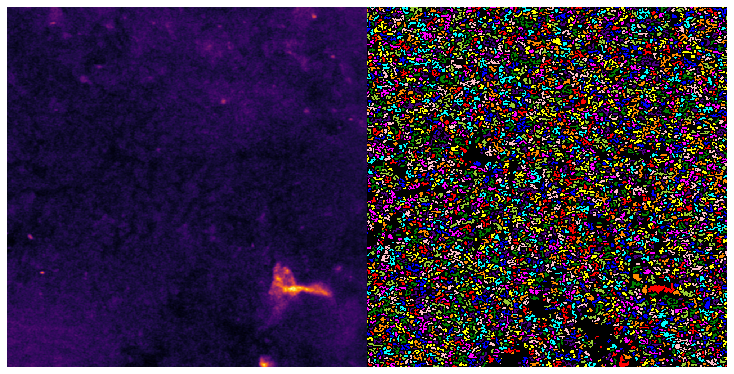

Spot channel  1


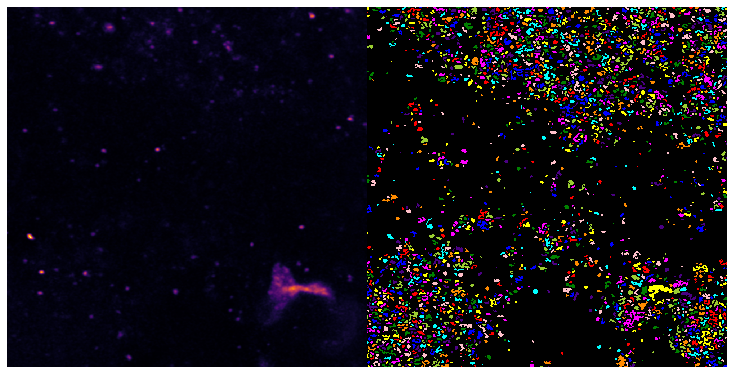

Spot channel  2


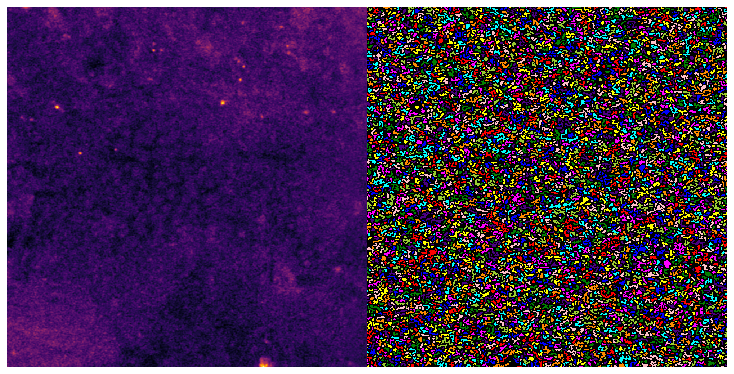

2021_08_26_plaqueamrintegrated_probe_plasmid_sample_hs_rep_2_fov_tile1
Cell channel  3


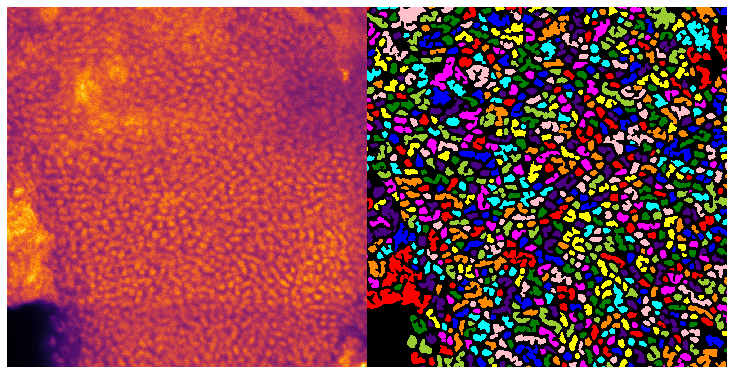

Spot channel  0


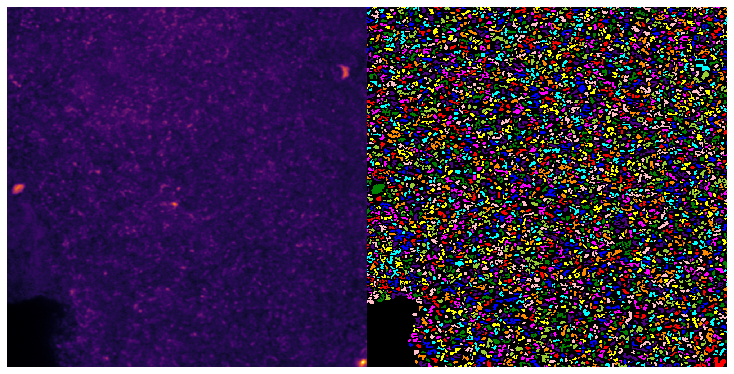

Spot channel  1


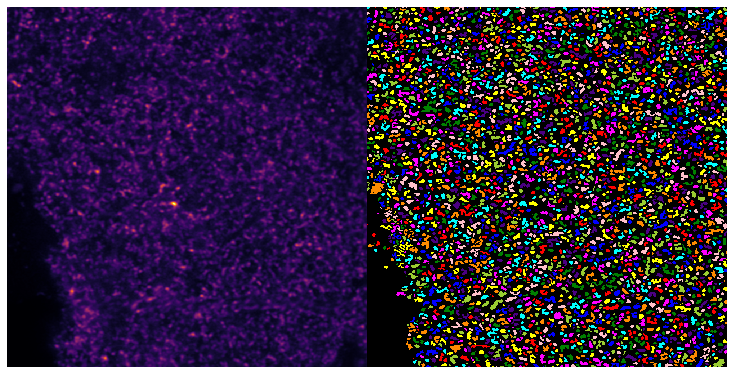

Spot channel  2


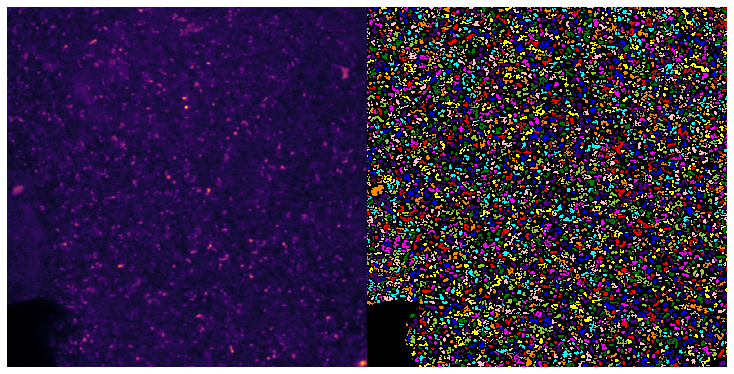

In [27]:
zf = [0.5,0.4]  # location of the zoom image as a fraction of the total axis len
zs = 1000  # size of the zoom box
for sn in sample_names:
    print(sn)
    _raw_npy_fn = config['output_dir'] + '/raw_npy/{sn}.npy'.format(sn=sn)
    _raw = sf.np.load(_raw_npy_fn)
    _r, _c = round(_raw.shape[0]*zf[0]), round(_raw.shape[1]*zf[1])
    _zc = [_r,_r+zs, _c, _c+zs]
    for ch in config['cell_seg']['channels']:
        print('Cell channel ',ch)
        _cell_seg_fn = (config['output_dir'] + '/cell_seg/{sn}/{sn}_chan_{ch}_cell_seg.npy'.format(sn=sn, ch=ch))
        _raw_chan = _raw[:,:,ch][_zc[0]:_zc[1],_zc[2]:_zc[3]]
        _seg = sf.np.load(_cell_seg_fn)[_zc[0]:_zc[1],_zc[2]:_zc[3]]
        ip.subplot_square_images([_raw_chan, ip.seg2rgb(_seg)], (1,2))
        ip.plt.show()
        ip.plt.close()
    for ch in config['spot_seg']['channels']:
        print('Spot channel ', ch)
        _cell_seg_fn = (config['output_dir'] + '/spot_seg/{sn}/{sn}_chan_{ch}_spot_seg.npy'.format(sn=sn, ch=ch))
        _raw_chan = _raw[:,:,ch][_zc[0]:_zc[1],_zc[2]:_zc[3]]
        _seg = sf.np.load(_cell_seg_fn)[_zc[0]:_zc[1],_zc[2]:_zc[3]]
        ip.subplot_square_images([_raw_chan, ip.seg2rgb(_seg)], (1,2))
        ip.plt.show()
        ip.plt.close()